In [50]:
import torch
import torch.nn as nn 
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import (
    intersection_over_union,
    non_max_suppression,
    mean_average_precision,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint
)

## Model

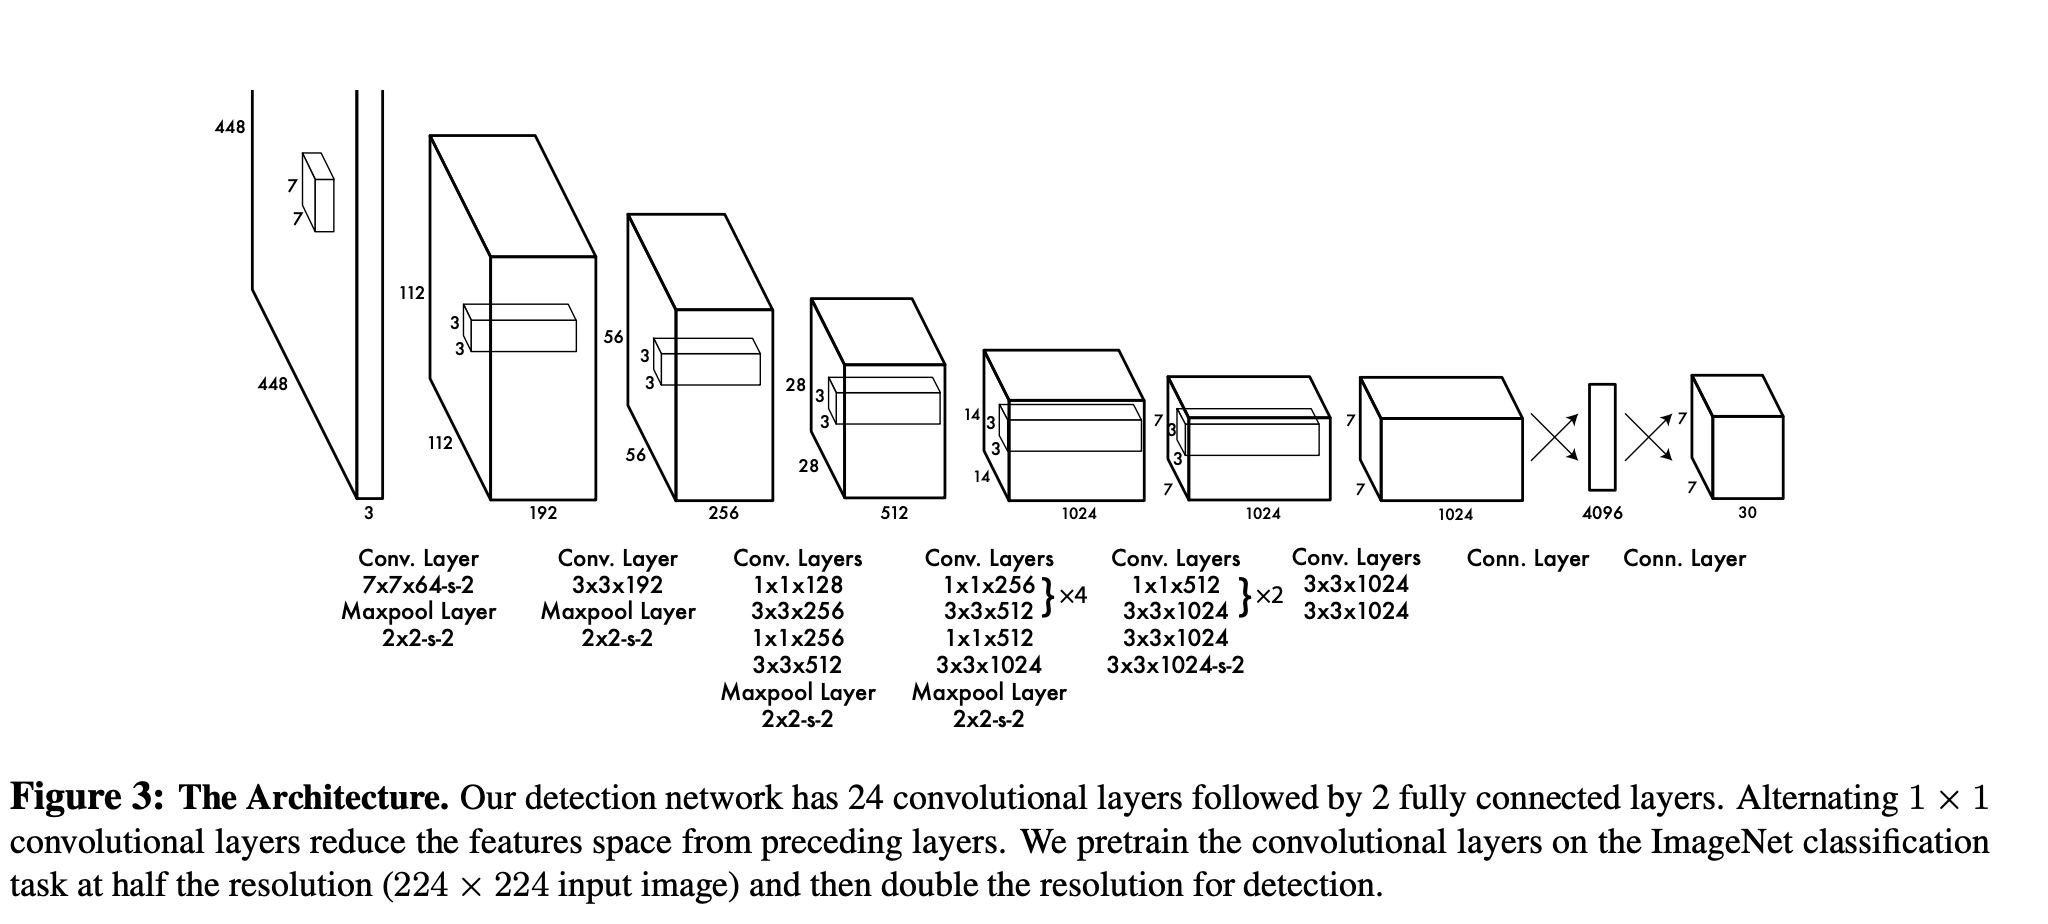

In [51]:
architecture_config = [
    #Tuple: (kernel_size, num_filters, stride, padding)
    (7, 64, 2, 3),
    'M',
    (3, 192, 1, 1),
    'M',
    (1,128,1,0),
    (3,256,1,1),
    (1,256,1,0),
    (3,512,1,1),
    'M',
    #List: contains tuples as before, 
    #aand how many times those should be repeated in sequence
    [(1,256,1,0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    'M',
    [(1,512,1,0),(3,1024,1,1),2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

In [52]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        #Why batchnorm? this was implemented in YOLO9000
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [53]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        #The super() function returns an object that represents the parent class.
        #Then it gets the methods it inherits
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        #Darknet: framework by the author
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        
    def forward(self,x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x,start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, x[1],
                                  kernel_size = x[0],
                                   stride = x[2], padding = x[3])]
                in_channels = x[1]
                
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2,stride=2)]
            elif type(x) == list:
                conv1 = x[0] #tuple with conv settings
                conv2 = x[1] #tuple with conv settings
                num_repeats = x[2]
                for i in range(num_repeats):
                    layers += [
                        CNNBlock(in_channels, 
                                 conv1[1], 
                                 kernel_size = conv1[0],
                                 stride = conv1[2], 
                                 padding = conv1[3])
                    ]
                    
                    layers += [
                        CNNBlock(conv1[1], #in channels come from conv1
                                 conv2[1], 
                                 kernel_size = conv2[0],
                                 stride = conv2[2], 
                                 padding = conv2[3])
                    ]
                    
                    in_channels = conv2[1]
                
        return nn.Sequential(*layers)
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(nn.Flatten(), 
                             nn.Linear(1024 * S * S, 496), #Paper uses 4096
                             nn.Dropout(0.0),
                             nn.LeakyReLU(0.1),
                             nn.Linear(496, S * S * (C + B * 5)) #Times 5 because it has a probability score + bounding boxes asociated to it  
                            # it will be reshaped to (S, S, 30), C + B*5 = 30
                            )

In [54]:
def test(S=7, B=2, C=20):
    model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn((2, 3,448, 448))
    print(model(x).shape)
    
test()

torch.Size([2, 1470])


### Loss Function

+ All are sum-squared errors
+ Indicators are choosen by highest IOU (intersection over union)

+ We start with the coordinate for the box

> First part:
    - Box coordinate of the mid point
    - Identity function:
        1 if there is an object in cell i (i goes from 0 to S^2, meaning every cell of the image) and bounding box j was responsible for outputing that bounding box
        
> Second part:
    - Is for the with and height of the box
    - It takes the square root to make sure that we prioritize small boxes equally as much as big ones.
    - The identity same as before.
    
+ Detect Objects in the box

> Third part:
    - C: probability that there is a box in the cell

> Fourth part:
    - If there was not an object in the cell

+ Classify objects

> Fifth part:
    - If there is an object in the cell:
        We go through each class and calculate probability for every class
        This could use a cross-entropy but to keep it simple the authors just used a regression loss

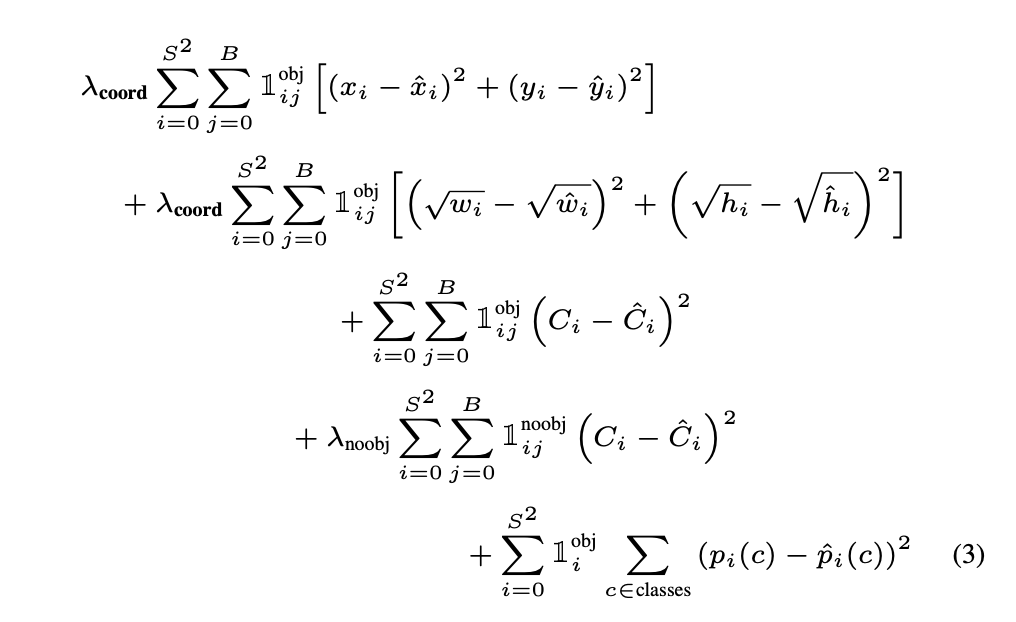

In [55]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2,C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5
    
    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[...,21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[...,21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)],dim = 0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3) #Identity of obj i
        
        ## For box coordinates
        
        box_predictions = exists_box * (
            bestbox * predictions[...,26:30] +
            (1 - bestbox) * predictions[..., 21:25]
        )
        
        box_targets = exists_box * target[...,21:25]
        #we take abs value and add 1e-6 to prevent negative sqrt and numerical stability
        box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4]) * torch.sqrt(torch.abs(box_predictions[...,2:4]) + 1e-6)
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4])
        
        # (N, S, S, 4) -> (N*S*S, 4)
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                            torch.flatten(box_targets, end_dim=-2)
                           )
        
        ## Object Loss
        pred_box = (
            bestbox * predictions[...,25:26] + (1 - bestbox) * predictions[...,20:21]
        )
        
        # (N*S*S)
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[...,20:21])
        )
        
        ## No object loss
        # (N, S, S, 1) -> (N, S*S)
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[...,20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[...,20:21], start_dim = 1)
        )
        
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[...,25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[...,20:21], start_dim = 1)
        )
        
        ## Class Loss
        
        # (N, S, S, 20) -> (N*S*S, 20)
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
            torch.flatten(exists_box * target[..., :20], end_dim=-2)
        )
        
        ## Put it all together
        
        loss = (
            self.lambda_coord * box_loss #first two rows
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )
        
        return loss
        

In [56]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Data

PascalVOC dataset: https://www.kaggle.com/aladdinpersson/pascalvoc-yolo

Current YOLO uses COCO

In [57]:
#This specifies how to load one example, then pytorch escalates it efficiently for the whole

class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, 
        S=7, B=2, C=20, transform=None
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace('\n','').split()
                ]
                boxes.append([class_label, x, y, width, height])
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        
        if self.transform:
            image, boxes = self.transform(image, boxes)
            
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )
            
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )
                label_matrix[i,j,21:25] = box_coordinates
                label_matrix[i,j, class_label] = 1
        
        return image, label_matrix
    

## Train

In [66]:
seed = 123
torch.manual_seed(seed)

#Hyperparameters
LEARNING_RATE = 2e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 30
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = 'overfit.pth.tar'
IMG_DIR = 'data/images'
LABEL_DIR = 'data/labels'

In [59]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self,img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
        
        return img, bboxes

transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [60]:
def train_fn(train_loader, model, optimizer, loss_fn):
    model.train()
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x,y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        #torch.autograd.set_detect_anomaly(True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #update progress bar
        loop.set_postfix(loss = loss.item())
        
    #print(f'Mean loss was {sum(mean_loss)/len(mean_loss)}')

In [67]:
def main():
    model = Yolov1(split_size = 7, num_boxes = 2, 
                   num_classes = 20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    model.train()
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
    
    train_dataset = VOCDataset(
        'data/100examples.csv',
        transform = transform,
        img_dir = IMG_DIR,
        label_dir = LABEL_DIR
    )
    
    test_dataset = VOCDataset(
        'data/test.csv',
        transform = transform,
        img_dir = IMG_DIR,
        label_dir = LABEL_DIR
    )
    
    train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = BATCH_SIZE,
        num_workers = NUM_WORKERS,
        pin_memory = PIN_MEMORY,
        shuffle = True,
        drop_last = False
        
    )
    
    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = BATCH_SIZE,
        num_workers = NUM_WORKERS,
        pin_memory = PIN_MEMORY,
        shuffle = True,
        drop_last = True
        
    )
    
    for epoch in range(EPOCHS):
        
        #for x, y in test_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold = 0.5,
        #                                    threshold = 0.4)
        #        plot_image(x[idx].permute(1,2,0).to('cpu'), bboxes)
        #    
        #    import sys
        #    sys.exit()
        
        
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, 
            threshold=0.4, device=DEVICE
        )
        
        #mean_avg_prec = mean_average_precision(
        #    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        #)
        #print(f"Train mAP: {mean_avg_prec}")
        
        train_fn(train_loader, model, optimizer, loss_fn)
        
    checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    #import time
    print('Done')    
    #time.sleep(20)
            
            

In [68]:
main()


=> Loading checkpoint


  0%|          | 0/7 [00:56<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#Replace darknet to resnet. resize image
#Data augmentation